In [38]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import re
from itertools import chain
from typing import List
from tqdm import tqdm

from IPython.display import SVG # to use Scalar Vector Graphics (SVG) not bitmaps, for cleaner lines

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw # to draw molecules
from rdkit.Chem.Draw import IPythonConsole # to draw inline in iPython
from rdkit.Chem import rdDepictor  # to generate 2D depictions of molecules
from rdkit.Chem.Draw import rdMolDraw2D # to draw 2D molecules using vectors
from rdkit.Chem.MolStandardize import rdMolStandardize

def draw_mol_with_SVG(mol, molSize=(450,150)):
    """Use SVG to draw an RDKit molecule, mol."""
    mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():        
        rdDepictor.Compute2DCoords(mc) # Compute 2D coordinates
    # Initialize the drawer with the size
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc) # Draw the molcule
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText() # Get the SVG string
    display(SVG(svg.replace('svg:',''))) # Fix the SVG string and display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
rhea_directions = pd.read_csv('/home/stef/bottle/data/mapping/rhea-directions.tsv', '\t')
rhea_smarts = pd.read_csv('/home/stef/bottle/data/mapping/rhea-reaction-smiles.tsv', '\t', header=None)
rhea_smarts.columns = ["rhea_id", "smarts"]
rhea_smarts.set_index('rhea_id', inplace=True)

/home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [40]:
# Rhea IDs w smarts are a subset of all ids in rhea-directions

rhea_all = set()
for col in rhea_directions.columns:
    rhea_all = rhea_all | set(rhea_directions.loc[:, col])
w_smarts = set(rhea_smarts.index.values)
w_smarts - rhea_all

set()

In [41]:
# Only rhea IDs in LR / RL have a smarts entry, and if there is one there are both!

codes = []
counts = []
for i, row in rhea_directions.iterrows():
    ct = 0
    code = ''
    for id in row:
        if id in w_smarts:
            ct += 1
            code += '1'
        else:
            code += '0'
    counts.append(ct)
    codes.append(code)

print(set(counts))
print(rhea_directions.columns)
print(set(codes))

{0, 2}
Index(['RHEA_ID_MASTER', 'RHEA_ID_LR', 'RHEA_ID_RL', 'RHEA_ID_BI'], dtype='object')
{'0000', '0110'}


In [42]:
# Create look up of (LR, RL) rhea ids from not LR, RL

lookup_directed_ids = {}

for i, row in rhea_directions.iterrows():
    lookup_directed_ids[row['RHEA_ID_MASTER']] = (row['RHEA_ID_LR'], row['RHEA_ID_RL'])
    lookup_directed_ids[row['RHEA_ID_BI']] = (row['RHEA_ID_LR'], row['RHEA_ID_RL'])

In [43]:
rhea_uniprot = pd.read_csv('/home/stef/bottle/data/mapping/rhea2uniprot_sprot.tsv', sep='\t')
up_pull = pd.read_csv('/home/stef/bottle/data/mapping/uniprotkb_reviewed_true_AND_proteins_wi_2024_02_29.tsv', sep='\t')
up_pull.set_index("Entry", inplace=True)

In [44]:
# Get rhea ids for up entries

rhea_up_pairs= set()
pattern = r'RHEA:(\d{1,6})' # Regular expression pattern
no_matches = []

for entry, row in up_pull.iterrows():
    cat_act = row["Catalytic activity"]
    if pd.isna(cat_act):
        no_matches.append(entry)
    else:
        matches = re.findall(pattern, cat_act)

        for match in matches:
            rhea_up_pairs.add((int(match), entry))

        if len(matches) == 0:
            no_matches.append(entry)

In [45]:
# Pull rhea-up pairs from rhea's tsv

rhea_up_pairs_alt = set()
for i, row in rhea_uniprot.iterrows():
    rhea_up_pairs_alt.add((row['RHEA_ID'], row['ID']))

In [46]:
len(rhea_up_pairs_alt ^ rhea_up_pairs) / len(rhea_up_pairs_alt | rhea_up_pairs)

0.006352646521386967

In [47]:
# Filter by smarts avail

def filter_pairs_by_smarts(pair):
    r = pair[0]
    if r in lookup_directed_ids:
        if lookup_directed_ids[r][0] in w_smarts or lookup_directed_ids[r][1] in w_smarts:
            return True
        else:
            return False
    else:
        return False

rhea_up_pairs_w_smarts = set(filter(filter_pairs_by_smarts, list(rhea_up_pairs)))
rhea_up_pairs_alt_w_smarts = set(filter(filter_pairs_by_smarts, list(rhea_up_pairs_alt)))

In [48]:
# After filtering by avail of smarts, the difference in rhea-upid pairs
# gotten by the two methods is small

len(rhea_up_pairs_w_smarts ^ rhea_up_pairs_alt_w_smarts) / len(rhea_up_pairs_alt_w_smarts | rhea_up_pairs_w_smarts)

0.004448221554483126

In [54]:
_, rheas_to_get = list(set(zip(*rhea_up_pairs_w_smarts | rhea_up_pairs_alt_w_smarts)))
with open("../artifacts/rheas_to_get_names.txt", 'w') as f:
    for elt in rheas_to_get:
        f.write(f"{elt}\n")

In [55]:
len(rheas_to_get)

296523

# Compare molecular standardization

In [12]:
smiles = set()
for i,row in rhea_smarts.iterrows():
    this_smiles = list(chain(*[elt.split('.') for elt in row['smarts'].split('>>')]))
    for smi in this_smiles:
        smiles.add(smi)

smiles = list(smiles)

# Get names from rhea smarts / smiles

In [47]:
smiles2chebi = pd.read_csv('/home/stef/bottle/data/mapping/rhea-chebi-smiles.tsv', sep='\t', header=None)
chebi2name = pd.read_csv('/home/stef/bottle/data/mapping/chebiId_name.tsv', sep='\t', header=None)
smiles2chebi.columns = ['chebi', 'smiles']
chebi2name.columns = ['chebi', 'smiles']
smiles2chebi.set_index('smiles', inplace=True)
chebi2name.set_index('chebi', inplace=True)

In [56]:
missing_chebi = []
missing_name = []
for smi in smiles:
    if smi not in smiles2chebi.index:
        missing_chebi.append(smi)
    else:
        found_name = []
        for elt in smiles2chebi.loc[smi, 'chebi']:
            found_name.append(elt in chebi2name.index)

        if not any(found_name):
            missing_name.append(smi)

In [60]:
len(missing_chebi), len(missing_name), len(smiles)

(6306, 5903, 12272)

In [67]:
len(smiles2chebi.index), len(smiles)

(12837, 12272)

In [68]:
standardize_smiles('O=C([O-])C1=CC=CC(C(=O)[O-])=C1')

[15:56:14] Initializing MetalDisconnector
[15:56:14] Running MetalDisconnector
[15:56:14] Initializing Normalizer
[15:56:14] Running Normalizer
[15:56:14] Initializing MetalDisconnector
[15:56:14] Running MetalDisconnector
[15:56:14] Initializing Normalizer
[15:56:14] Running Normalizer
[15:56:14] Running LargestFragmentChooser
[15:56:14] Fragment: O=C([O-])c1cccc(C(=O)[O-])c1
[15:56:14] New largest fragment: O=C([O-])c1cccc(C(=O)[O-])c1 (16)
[15:56:14] Running Uncharger
[15:56:14] Removed negative charge.
[15:56:14] Removed negative charge.


'O=C(O)c1cccc(C(=O)O)c1'

In [69]:
'O=C(O)c1cccc(C(=O)O)c1' in smiles2chebi.index

False

In [70]:
'[O-]C(=O)c1cccc(c1)C([O-])=O' in smiles2chebi.index

False

In [61]:
missing_chebi

['*C(=O)N[C@@H](CO[C@@H]1O[C@H](CO)[C@@H](O[C@@H]2O[C@H](CO)[C@H](O[C@@H]3O[C@H](CO)[C@H](O)[C@H](O[C@@H]4O[C@H](CO)[C@H](O)[C@H](O[C@]5(C(=O)[O-])C[C@H](O)[C@@H](NC(C)=O)[C@]([H])([C@H](O)[C@H](O)CO)O5)[C@H]4O)[C@H]3NC(C)=O)[C@H](O[C@]3(C(=O)[O-])C[C@H](O)[C@@H](NC(C)=O)[C@]([H])([C@H](O)[C@@H](CO)O[C@]4(C(=O)[O-])C[C@H](O)[C@@H](NC(C)=O)[C@]([H])([C@H](O)[C@@H](CO)O[C@]5(C(=O)[O-])C[C@H](O)[C@@H](NC(C)=O)[C@]([H])([C@H](O)[C@H](O)CO)O5)O4)O3)[C@H]2O)[C@H](O)[C@H]1O)[C@@H](*)O',
 'NC(=[NH2+])NCCC[C@H]([NH3+])C(=O)OP(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C2N=CN=C3N)[C@H](O)[C@@H]1O',
 'O=C([O-])C1=CC=CC(C(=O)[O-])=C1',
 '*/C=C(C)/C=C/C=C(C)/C=C/C1=C(C)C(C)=CC=C1C',
 '*N[C@@H](CCCCNC(=O)CCCC[C@@H]1SC[C@]2([H])N(C(=O)[O-])C(=O)N[C@]12[H])C(*)=O',
 '[H]C(=O)C1=CC=C(S(=O)(=O)[O-])C=C1',
 '[H][C@@]12C[C@H](O)CC[C@]1(C)[C@@]1([H])C[C@H](O)[C@@]3(C)[C@@]([H])(CC[C@]3([H])[C@H](C)CCC(=O)[O-])[C@]1([H])[C@@H](O)C2',
 'CC(C)=CCC1=CC(C(=O)[O-])=CC=C1O',
 'O=C1C2=C(O)C=C([O-])C=C2O/C(C2=CC=C(O)C=C2)=C\

In [63]:
for i, row in rhea_smarts.iterrows():
    smarts = row['smarts']
    smi = list(chain(*[elt.split('.') for elt in smarts.split('>>')]))
    if 'O=C([O-])C1=CC=CC(C(=O)[O-])=C1' in smi:
        print(i, row)
        break

61637 smarts    CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H]...
Name: 61637, dtype: object


# Tangent on aromaticity

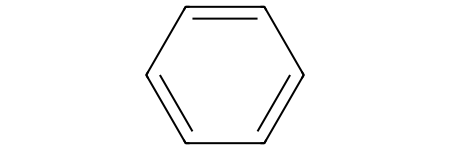

In [24]:
Chem.MolFromSmiles('c1ccccc1')

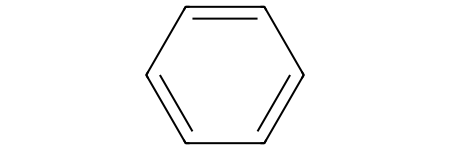

In [28]:
Chem.MolFromSmiles('C1=C-C=C-C=C1')

In [30]:
Chem.MolToSmiles(Chem.MolFromSmiles('C1=C-C=C-C=C1'))

'c1ccccc1'

In [33]:
Chem.CanonSmiles('C1=C-C=C-C=C1')

'c1ccccc1'

In [36]:
mol = Chem.MolFromSmiles('C1=C-C=C-C=C1')
for b in mol.GetBonds():
    print(b.GetBondType())

AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
